# Vision Transformer Exercise by using Huggingface libraries

Reference : https://huggingface.co/blog/fine-tune-vit

## Setup

In [1]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model_name = 'google/vit-base-patch16-224'
model_name = 'google/vit-base-patch16-224-in21k'
model_predict = ViTForImageClassification.from_pretrained(model_name)
model_predict.to(device)

processor = ViTImageProcessor.from_pretrained(model_name)
processor.size

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'height': 224, 'width': 224}

### Load data

In [2]:
import datasets

datasets.logging.set_verbosity(datasets.logging.ERROR)
dataset = datasets.load_dataset('cifar10')
#dataset = datasets.load_dataset('beans')
dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [3]:
dataset_train_val = dataset['train'].train_test_split(0.2)
#dataset_train = dataset_train_val['train'].select(range(5000))
#dataset_val = dataset_train_val['test'].select(range(1000))
#dataset_test = dataset['test'].select(range(1000))
dataset_train = dataset_train_val['train']
if len(dataset_train) > 10000:
    dataset_train = dataset_train.select(range(10000))
dataset_val = dataset_train_val['test']
if len(dataset_val) > 2000:
    dataset_val = dataset_val.select(range(2000))
dataset_test = dataset['test']
if len(dataset_test) > 2000:
    dataset_test = dataset_test.select(range(2000))


In [4]:
print(dataset_train.features.keys())
image_name = 'image'
label_name = 'labels'
for k in dataset_train.features.keys():
    if k == 'img':
        image_name = k
    if k == 'label':
        label_name = k
print(dataset_train)
print(dataset_val)
print(dataset_test)

print(f'image_name = {image_name}, label_name = {label_name}')

dict_keys(['img', 'label'])
Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 2000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 2000
})
image_name = img, label_name = label


In [5]:
id2label = {i: l for i, l in enumerate(dataset_train.features[label_name].names)}
label2id = {l: i for i, l in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

## Predict test by default model without fine-tuning

In [6]:
from PIL import Image

def predict(imgfile, print_flg=False):
    img = Image.open(imgfile)
    inputs = processor(images=img, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    print(f'pixel_values shape = {pixel_values.shape}')
    with torch.no_grad():
      outputs = model_predict(pixel_values)
    logits = outputs.logits
    print(f'logits shape = {logits.shape} , logits type = {type(logits)}, model type = {type(model_predict)}')
    if print_flg:
       print(f'logits = {logits}')
    prediction = logits.argmax(-1)
    print(f"Predicted class:", model_predict.config.id2label[prediction.item()])
    print(f"prediction type = {prediction}, prediction item = {prediction.item()}")
    return prediction

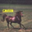

torch.Size([1, 3, 224, 224])
ImageClassifierOutput(loss=None, logits=tensor([[ 0.1252, -0.0470]], device='cuda:0'), hidden_states=None, attentions=None)
torch.Size([1, 2])
Predicted = 0 :  LABEL_0
Actual = 7 : horse


In [7]:
import torch

idx = 100
display(dataset_train[idx][image_name])
inputs = processor(images=dataset_train[idx][image_name], return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
print(pixel_values.shape)
with torch.no_grad():
    outputs = model_predict(pixel_values)
print(outputs)
logits = outputs.logits
print(logits.shape)
prediction = logits.argmax(-1)
print(f"Predicted = {prediction.item()} :  {model_predict.config.id2label[prediction.item()]}")
print(f"Actual = {dataset_train[idx][label_name]} : {id2label[dataset_train[idx][label_name]]}")

## Fine Tuning

### Data Preprocess

In [8]:
from transformers import ViTFeatureExtractor

# ViTImageProcessorと実体は同じ (https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/models/vit/feature_extraction_vit.py)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
dataset_train[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 6}

In [10]:
# transformはdatasetのitemがsliceされた分まとまって呼ばれる(Trainerからは1個づつ呼ばれる)
# 例)
#  item1 = {key-A:value-A-1, key-B:value-B-1, ...}, item2 = {key-A:value-A-2, key-B:value-B-2, ...}, 
#   => slice_items = {key-A: [value-A-1, value-A-2, ...], key-B: [value-B-1, value-B-2...]} 
def transform_func(slice_items):
    inputs = feature_extractor([x for x in slice_items[image_name]], return_tensors='pt')
    inputs[label_name] = slice_items[label_name]
    return inputs

transformed_dataset_train = dataset_train.with_transform(transform_func)
transformed_dataset_val = dataset_val.with_transform(transform_func)
transformed_dataset_test = dataset_test.with_transform(transform_func)
transformed_dataset_train[0:2]


{'pixel_values': tensor([[[[ 0.1137,  0.1137,  0.1137,  ..., -0.1529, -0.1529, -0.1529],
          [ 0.1137,  0.1137,  0.1137,  ..., -0.1529, -0.1529, -0.1529],
          [ 0.1137,  0.1137,  0.1137,  ..., -0.1529, -0.1529, -0.1529],
          ...,
          [-0.2078, -0.2078, -0.2078,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2078, -0.2078, -0.2078,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2078, -0.2078, -0.2078,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.0902,  0.0902,  0.0902,  ...,  0.0196,  0.0196,  0.0196],
          [ 0.0902,  0.0902,  0.0902,  ...,  0.0196,  0.0196,  0.0196],
          [ 0.0902,  0.0902,  0.0902,  ...,  0.0196,  0.0196,  0.0196],
          ...,
          [-0.0431, -0.0431, -0.0431,  ..., -0.2235, -0.2235, -0.2235],
          [-0.0431, -0.0431, -0.0431,  ..., -0.2235, -0.2235, -0.2235],
          [-0.0431, -0.0431, -0.0431,  ..., -0.2235, -0.2235, -0.2235]],

         [[-0.3725, -0.3725, -0.3725,  ..., -0.4431, -0.4431, -0.4431],
          [-0

In [11]:
import numpy as np
import evaluate

# collateはbatchサイズ分まとまって呼ばれるので tensorに変換して返す (transformでfeature_extractor適用済みの場合)
# trainだけの場合feature_extractorもここで処理すれば 前述の transform_funcは不要になる（はず）だが、evaluationのためcollate前にfeature extractorを通しておく必要がある
def collate_func(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x[label_name] for x in batch])
    }

accuracy_metric = evaluate.load('accuracy')

def metrics_func(p):
    return accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [12]:
# from_pretrained keyward arguments are passed to PretrainedConfig (https://huggingface.co/docs/transformers/main_classes/configuration#transformers.PretrainedConfig)
# num_labels, id2label, label2id are the parameters of PretrainedConfig for Classification
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(id2label), id2label=id2label, label2id=label2id)
#, ignore_mismatched_sizes=True)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train

In [13]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir="./vit-base-finetuning-test",
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="tensorboard",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_func,
    compute_metrics=metrics_func,
    train_dataset=transformed_dataset_train,
    eval_dataset=transformed_dataset_val,
    tokenizer=feature_extractor
)

Using cuda_amp half precision backend


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics('train', train_results.metrics)
trainer.save_metrics('train', train_results.metrics)
trainer.save_state()

### Evaluate

In [15]:
metrics_val = trainer.evaluate(transformed_dataset_val)
trainer.log_metrics('eval', metrics_val)
trainer.save_metrics('eval', metrics_val)

metrics_test = trainer.evaluate(transformed_dataset_test)
trainer.log_metrics('test', metrics_test)
trainer.save_metrics('test', metrics_test)

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


  0%|          | 0/125 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9545
  eval_loss               =     0.1926
  eval_runtime            = 0:00:07.75
  eval_samples_per_second =    258.006
  eval_steps_per_second   =     16.125


  0%|          | 0/125 [00:00<?, ?it/s]

***** test metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.959
  eval_loss               =     0.1907
  eval_runtime            = 0:00:07.81
  eval_samples_per_second =    256.073
  eval_steps_per_second   =     16.005


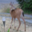

torch.Size([1, 3, 224, 224])
torch.Size([1, 10])
Predicted class :  deer
Actual class :  deer


In [16]:
idx = 100
display(dataset_test[idx][image_name])
inputs = processor(images=dataset_test[idx][image_name], return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
print(pixel_values.shape)
with torch.no_grad():
    outputs = model(pixel_values)
logits = outputs.logits
print(logits.shape)
prediction = logits.argmax(-1)
print("Predicted class : ", model.config.id2label[prediction.item()])
print("Actual class : ", model.config.id2label[dataset_test[idx][label_name]])

In [17]:
import pandas as pd

result = {'OK': 0, 'NG': 0}
result2 = {}
for idx in range(len(dataset_test)):
    inputs = processor(images=dataset_test[idx][image_name], return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    with torch.no_grad():
        outputs = model(pixel_values)
    logits = outputs.logits
    prediction = logits.argmax(-1)
    true_label = dataset_test[idx][label_name]
    key = 'OK' if prediction.item() == true_label else 'NG'
    result[key] = result[key] + 1
    
    result_per_label = result2.setdefault(id2label[true_label], {})
    result_per_label[key] = result_per_label.setdefault(key, 0) + 1

result_data = {'label': [], 'accuracy': [], 'OK': [], 'NG': [], 'TOTAL': []}
for k, v in result2.items():
    ok = v.get('OK', 0)
    ng = v.get('NG', 0)
    result_data['label'].append(k)
    result_data['accuracy'].append(ok/(ok+ng))
    result_data['OK'].append(ok)
    result_data['NG'].append(ng)
    result_data['TOTAL'].append(ok+ng)

total = result['OK'] + result['NG']
result_data['label'].append('all')
result_data['accuracy'].append(result['OK']/(total))
result_data['OK'].append(result['OK'])
result_data['NG'].append(result['NG'])
result_data['TOTAL'].append(total)

df_accuracy = pd.DataFrame(result_data)
df_accuracy

,label,accuracy,OK,NG,TOTAL
0,cat,0.914573,182,17,199
1,ship,0.967742,210,7,217
2,airplane,0.974490,191,5,196
3,frog,0.981481,212,4,216
4,automobile,0.964646,191,7,198
5,truck,0.965517,196,7,203
6,dog,0.908108,168,17,185
7,horse,0.979275,189,4,193
8,deer,0.974747,193,5,198
9,bird,0.953846,186,9,195


In [18]:
import pandas as pd
df_train_log_tmp = pd.DataFrame(trainer.state.log_history)
df_train_log = df_train_log_tmp[df_train_log_tmp['eval_accuracy'].isnull()][['loss', 'learning_rate', 'epoch', 'step']].reset_index(drop=True)
display(df_train_log.head(10))
df_train_eval_log = df_train_log_tmp[~df_train_log_tmp['eval_accuracy'].isnull()][['epoch', 'step', 'eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']].reset_index(drop=True)
display(df_train_eval_log.head(10))

,loss,learning_rate,epoch,step
0,2.1769,0.000200,0.01,10
1,1.8119,0.000199,0.02,20
2,1.3969,0.000199,0.02,30
3,1.1679,0.000198,0.03,40
4,0.9264,0.000198,0.04,50
5,0.9068,0.000198,0.05,60
6,0.7919,0.000197,0.06,70
7,0.6830,0.000197,0.06,80
8,0.5890,0.000196,0.07,90
9,0.8122,0.000196,0.08,100


,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.08,100,0.512354,0.8995,7.7459,258.202,16.138
1,0.16,200,0.478266,0.8680,7.6130,262.709,16.419
2,0.24,300,0.414870,0.8860,7.6575,261.180,16.324
3,0.32,400,0.569641,0.8285,7.6847,260.258,16.266
4,0.40,500,0.348265,0.8980,7.7132,259.297,16.206
5,0.48,600,0.523978,0.8535,7.7125,259.320,16.207
6,0.56,700,0.371732,0.8920,7.7033,259.630,16.227
7,0.64,800,0.371396,0.8925,7.6736,260.634,16.290
8,0.72,900,0.455156,0.8640,7.6644,260.948,16.309
9,0.80,1000,0.491928,0.8535,7.6505,261.420,16.339


In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=['train loss', 'learning rate'])

fig.add_trace(go.Scatter(x=df_train_log['epoch'], y=df_train_log['loss'], name='train_loss'), row=1, col=1)
fig.update_xaxes(title="epoch", row=1, col=1)
fig.update_yaxes(title="loss", row=1, col=1)
fig.add_trace(go.Scatter(x=df_train_log['epoch'], y=df_train_log['learning_rate'], name='accuracy'), row=1, col=2)
fig.update_xaxes(title="epoch", row=1, col=2)
fig.update_yaxes(title="accuracy", row=1, col=1)
fig.show()

In [20]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Eval loss', 'Eval accuracy'])

fig.add_trace(go.Scatter(x=df_train_eval_log['epoch'], y=df_train_eval_log['eval_loss'], name='train_loss'), row=1, col=1)
fig.update_xaxes(title="epoch", row=1, col=1)
fig.update_yaxes(title="loss", row=1, col=1)
fig.add_trace(go.Scatter(x=df_train_eval_log['epoch'], y=df_train_eval_log['eval_accuracy'], name='accuracy'), row=1, col=2)
fig.update_xaxes(title="epoch", row=1, col=2)
fig.update_yaxes(title="accuracy", row=1, col=1)
fig.show()